In [109]:
import math
import fiona
from shapely.geometry import shape
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.prepared import prep
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
CITIES = ["Zürich", "Genève", "Basel", "Lausanne", "Bern", "Winterthur"] # cities larger than 100k
ROOFTOP_PV = 250
DATATYPE = np.float32

# Discriminate cities in rooftop model?

Currently, we are using one model for rooftop availability. It is derived from data on each roof in Switzerland. Part of the model is a factor that maps from building footprint to available rooftop area. Intuitively one would think that there is a difference between buildings in the city and buildings in rural areas. My guess is that rural buildings have larger roofs compared to their building foot print. Can we see that in the data?

## Read and prepare data

### Sonnendach.ch data

In [12]:
municipalities = gpd.read_file("../build/municipal/units.geojson")
swiss_municipalities = municipalities[municipalities.country_code == "CHE"].copy()
cities = swiss_municipalities[swiss_municipalities.name.isin(CITIES)]
rural = swiss_municipalities.dissolve(by="country_code").difference(cities.dissolve(by="country_code"))

In [3]:
with fiona.open("../data/sonnendach/SOLKAT_20180827.gdb/", layer="SOLKAT_CH_DACH") as f_in:
    crs = f_in.crs
    points = [shape(feat["geometry"]).centroid for feat in f_in]

In [42]:
roofs = gpd.GeoDataFrame(
    geometry=points,
    crs=crs,
    data=pd.read_csv("../build/swiss/roofs-without-geometry.csv", index_col=0)
).to_crs(rural.crs)

/Users/trtim/miniconda3/envs/possibility-for-electricity-autarky/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [63]:
pre_rural = prep(rural.iloc[0])
rural_mask = pd.Series(
    index=roofs.index,
    data=[pre_rural.intersects(roof) for roof in roofs.geometry]
)

In [215]:
cities

,country_code,id,name,type,proper,geometry
120341,CHE,CH01100230,Winterthur,commune,1,"(POLYGON ((8.758186 47.54665849900005, 8.77583..."
120354,CHE,CH01120261,Zürich,commune,1,(POLYGON ((8.510740500000054 47.43218150000006...
120560,CHE,CH02460351,Bern,commune,1,"(POLYGON ((7.452985 46.98314950000008, 7.45525..."
121205,CHE,CH12002701,Basel,commune,1,"(POLYGON ((7.590391 47.589534, 7.6049385000000..."
122205,CHE,CH22255586,Lausanne,commune,1,"(POLYGON ((6.629861 46.57866850100004, 6.61772..."
122552,CHE,CH25006621,Genève,commune,1,"(POLYGON ((6.136237 46.230554, 6.1503375000000..."


In [199]:
pre_urban = prep(cities.dissolve(by="country_code").iloc[0].geometry)
urban_mask = pd.Series(
    index=roofs.index,
    data=[pre_urban.intersects(roof) for roof in roofs.geometry]
)

In [222]:
pre_zurich = prep(cities.loc[120354].geometry)
zurich_mask = pd.Series(
    index=roofs.index,
    data=[pre_zurich.intersects(roof) for roof in roofs.geometry]
)

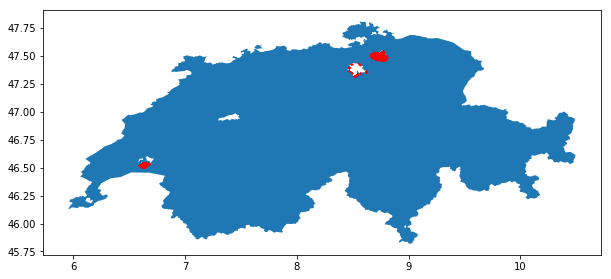

In [223]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
rural.plot(ax=ax)
roofs[urban_mask][:100000].plot(ax=ax, color="r", markersize=0.1)

In [162]:
MIN_ROOF_SIZE = 10 # @BFE:2016 "Berechnung Potential in Gemeinden"
MAX_FLAT_TILT = 10 # @BFE:2016 "Berechnung Potential in Gemeinden"
SINGLE_FAMILY_BUILDING = 1021 # GKAT @BFE:2016 "Berechnung Potential in Gemeinden"
MULTI_FAMILY_BUILDING = 1025 # GKAT @BFE:2016 "Berechnung Potential in Gemeinden"
FALLBACK_BUILDING_TYPE = 1010 # GKAT @BFE:2016 "Berechnung Potential in Gemeinden"

def theoretic_to_actual_area(row):
    # method and values from @BFE:2016 "Berechnung Potential in Gemeinden"
    if row.NEIGUNG <= 10:
        return row.FLAECHE * _theoretic_to_actual_area_flat_roofs_factor(row)
    else:
        return row.FLAECHE * 0.7


def _theoretic_to_actual_area_flat_roofs_factor(row):
    if row.GKAT == SINGLE_FAMILY_BUILDING:
        return 0.7
    elif row.GKAT == MULTI_FAMILY_BUILDING:
        if row.FLAECHE < 1000:
            return 0.6 * 0.7
        else:
            return 0.6 * 0.8
    else:
        if row.FLAECHE < 1000:
            return 0.7
        else:
            return 0.8

In [163]:
sonnendach = pd.read_csv("../build/swiss/roofs-without-geometry.csv", index_col=0)
sonnendach = sonnendach.merge(
    pd.read_csv("../build/swiss/building-categories.csv", index_col=0),
    left_on="GWR_EGID",
    right_index=True,
    how="left"
)
sonnendach["GKAT"].fillna(value=FALLBACK_BUILDING_TYPE, inplace=True)
sonnendach["GKAT"] = sonnendach["GKAT"].astype(pd.np.int16)
sonnendach = sonnendach[sonnendach.FLAECHE >= MIN_ROOF_SIZE]
roof_area_km2 = sonnendach.apply(theoretic_to_actual_area, axis=1) / 1e6

In [224]:
rural_rooftop_area_km2 = roof_area_km2.loc[~urban_mask].sum()
urban_rooftop_area_km2 = roof_area_km2.loc[urban_mask].sum()
zurich_rooftop_area_km2 = roof_area_km2.loc[zurich_mask].sum()

### ESM data

In [110]:
def determine_pixel_areas(crs, bounds, resolution):
    """Returns a raster in which the value corresponds to the area [km2] of the pixel.

    This assumes the data comprises square pixel in WGS84.

    Parameters:
        crs: the coordinate reference system of the data (must be WGS84)
        bounds: an object with attributes left/right/top/bottom given in degrees
        resolution: the scalar resolution (remember: square pixels) given in degrees
    """
    # the following is based on https://gis.stackexchange.com/a/288034/77760
    # and assumes the data to be in WGS84
    assert crs == rasterio.crs.CRS.from_epsg("4326") # WGS84
    width = int((bounds.right - bounds.left) / resolution)
    height = int((bounds.top - bounds.bottom) / resolution)
    latitudes = np.linspace(
        start=bounds.top,
        stop=bounds.bottom,
        num=height,
        endpoint=True,
        dtype=np.float64
    )
    varea_of_pixel = np.vectorize(lambda lat: _area_of_pixel(resolution, lat))
    pixel_area = varea_of_pixel(latitudes) # vector
    return pixel_area.repeat(width).reshape(height, width).astype(np.float64)


def _area_of_pixel(pixel_size, center_lat):
    """Calculate km^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in km^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = math.sqrt(1 - (b / a)**2)
    area_list = []
    for f in [center_lat + pixel_size / 2, center_lat - pixel_size / 2]:
        zm = 1 - e * math.sin(math.radians(f))
        zp = 1 + e * math.sin(math.radians(f))
        area_list.append(
            math.pi * b**2 * (
                math.log(zp / zm) / (2 * e) +
                math.sin(math.radians(f)) / (zp * zm)))
    return pixel_size / 360. * (area_list[0] - area_list[1]) / 1e6

In [219]:
with rasterio.open("../build/technically-eligible-land.tif") as src:
    rural_categories = rasterio.mask.mask(src, rural, crop=False)[0].reshape(16200, 19008)
    urban_categories = rasterio.mask.mask(src, cities.geometry, crop=False)[0].reshape(16200, 19008)
    zurich_categories = rasterio.mask.mask(src, cities.loc[120354].geometry, crop=False)[0].reshape(16200, 19008)
    meta = src.meta
    bounds = src.bounds
    resolution = src.res[0]

pixel_area = determine_pixel_areas(meta["crs"], bounds, resolution).astype(DATATYPE)
with rasterio.open("../build/esm-class50-buildings.tif") as f_building_share:
    pixel_area = pixel_area * f_building_share.read(1)
rural_areas = pixel_area.copy()
urban_areas = pixel_area.copy()
zurich_areas = pixel_area.copy()
rural_areas[rural_categories != ROOFTOP_PV] = 0
urban_areas[urban_categories != ROOFTOP_PV] = 0
zurich_areas[zurich_categories != ROOFTOP_PV] = 0

## Compare

In [207]:
print(f"Rural rooftop area according to sonnendach.ch: {rural_rooftop_area_km2:.0f}km2")
print(f"Rural building footprints according to ESM: {rural_areas.sum():.0f}km2")
print(f"Rural correction factor: {rural_rooftop_area_km2 / rural_areas.sum():.2f}")

Rural rooftop area according to sonnendach.ch: 415km2
Rural building footprints according to ESM: 982km2
Rural correction factor: 0.42


In [208]:
print(f"Urban rooftop area according to sonnendach.ch: {urban_rooftop_area_km2:.0f}km2")
print(f"Urban building footprints according to ESM: {urban_areas.sum():.0f}km2")
print(f"Urban correction factor: {urban_rooftop_area_km2 / urban_areas.sum():.2f}")

Urban rooftop area according to sonnendach.ch: 27km2
Urban building footprints according to ESM: 70km2
Urban correction factor: 0.38


In [225]:
print(f"Zurich rooftop area according to sonnendach.ch: {zurich_rooftop_area_km2:.0f}km2")
print(f"Zurich building footprints according to ESM: {zurich_areas.sum():.0f}km2")
print(f"Zurich correction factor: {zurich_rooftop_area_km2 / zurich_areas.sum():.2f}")

Zurich rooftop area according to sonnendach.ch: 9km2
Zurich building footprints according to ESM: 25km2
Zurich correction factor: 0.36


## Conclusion

There is evidence that the statistical model for urban areas is different than for rural areas in Switzerland:

For every squaremeter of rural building footprint, sonnendach.ch finds 0.42 squaremeter usable rooftop area. For the same building footprint in the six largest Swiss cities, they find only 0.38 squarementer usable rooftop area. That means there is 10% less rooftop area in these cities compared to the country side on average.

The difference is even stronger when looking at Zurich only, Switzerlands largest city: here, only 0.36 squaremeter usable rooftop area is found per squaremeter building footprint; more than 14% less than in the country side. Given that many cities in Europe are larger than Zurich (and/or more dense, which may be even more important), I would speculate that many places in Europe see even less available rooftop space per building footprint.

As rural buildings dominate in Switzerland, the total average is close to the rural average. Hence, in our results, rural rooftop pv potential is almost correct, while urban rooftop pv potential is 10% too high in average --- Zurich rooftop pv potential is even 14% too high.

This speaks in favour of having more than one statistical model in our analysis. However, it is not clear how to discriminate: what is the driving factor? Is it urban infrastructure? Is it population density? Furthermore it is unknown how and in which way that applies to other countries.